In [178]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Sum, Count
from matplotlib import gridspec

from utils.utils import *

import statsmodels.formula.api as sm, statsmodels.stats.api as sms


from run_id import run_id

run_id = 654

runstat = RunStats.objects.get(pk=run_id)

In [3]:
ar5 = AR.objects.get(ar=5)

docs = Doc.objects.filter(query=runstat.query,PY__lte=ar5.end)

docs.count()

181340

In [218]:
citations = IPCCRef.objects.all()

citations.count()

matched = citations.filter(doc__isnull=False)

unmatched = citations.filter(doc__isnull=True)

print("Matched {} documents\n".format(matched.count()))

print("Didn't match {} documents\n".format(unmatched.count()))

print("Matched {}% of documents\n".format(matched.count()/(matched.count()+unmatched.count())))

Matched 27100 documents

Didn't match 46421 documents

Matched 0.36860216808802926% of documents



In [163]:
df = pd.DataFrame.from_dict(list(unmatched.values('text','year')))
df.head()

,text,year
0,Coastal Sensitivity to Sea-Level Rise: A Focu...,2009
1,Could P-C move into financial services backfi...,2000
2,Pastoralism and D r o u g h t in T u r k a n ...,1990
3,SCENGEN: A Climate Change SCENario GENerato...,1995
4,Growth and yield of CO2 ennched wheat under wa...,1979


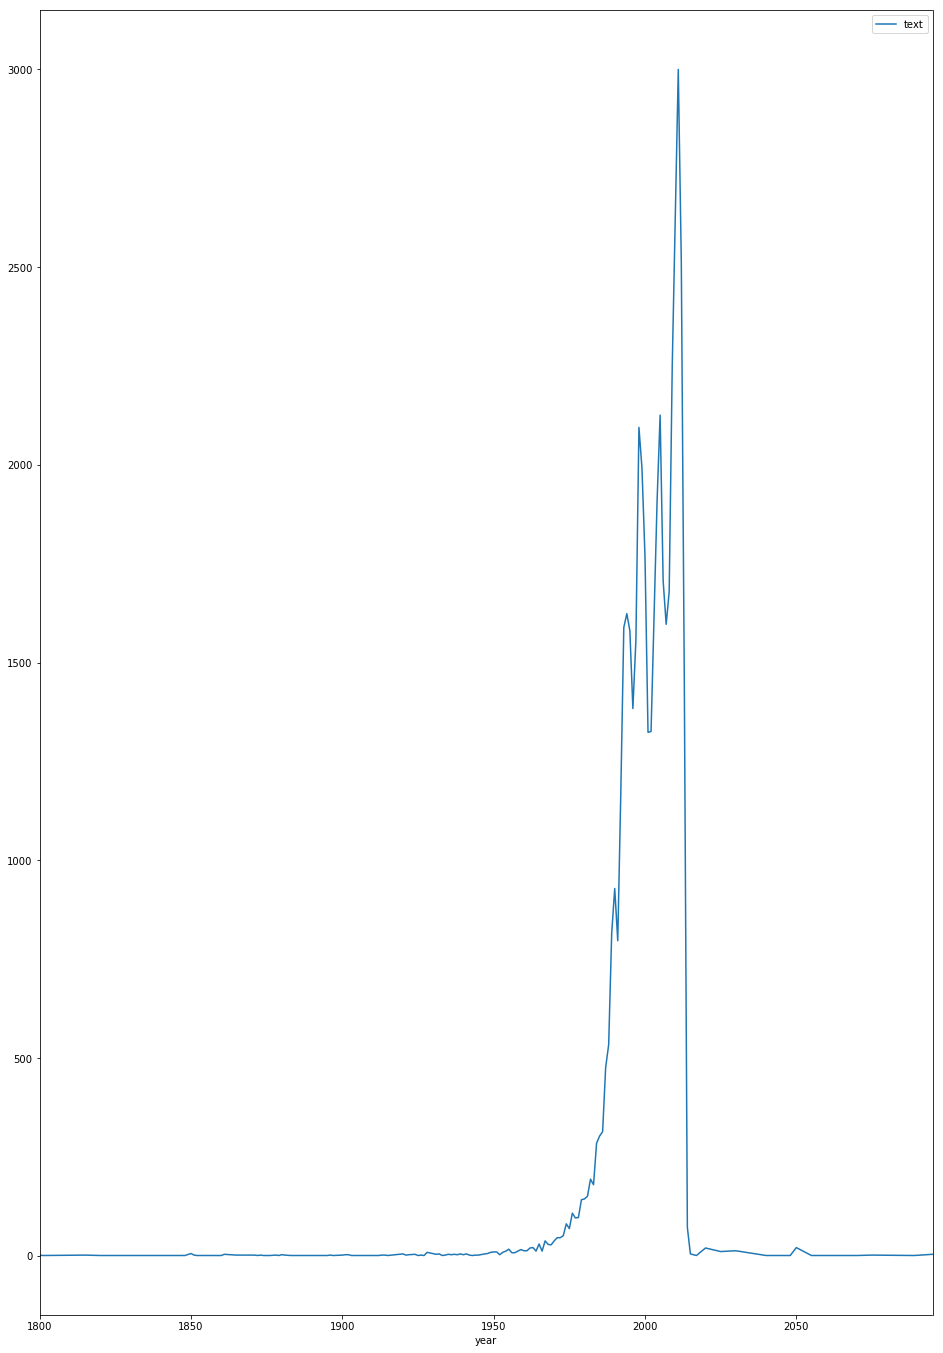

In [177]:
df.groupby(['year']).count().plot()

plt.show()

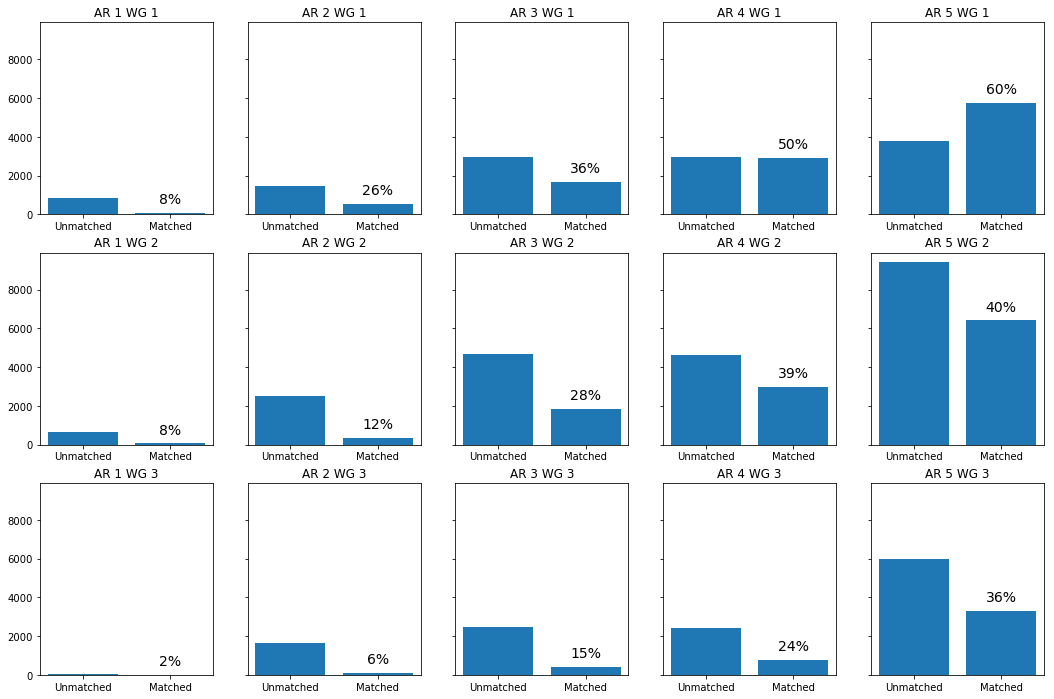

In [216]:
plt.rcParams["figure.figsize"] = [18,12]

fig, axs = plt.subplots(
    nrows=3,
    ncols=5,
    sharey=True#,
    #gridspec_kw=dict(hspace=0.4,)
)

for wg in WG.objects.all().order_by('ar','wg'):
    ax = axs[wg.wg-1][wg.ar.ar-1]
    irs = IPCCRef.objects.filter(
        ar=wg.ar,
        wg=wg
    )
    matched = irs.filter(doc__isnull=False).count()
    unmatched = irs.filter(doc__isnull=True).count()
    pcntage = round(matched / (matched+unmatched) * 100)
    ax.text(1,matched+500,"{}%".format(pcntage),ha="center",fontsize=14)
    ax.bar([0,1],[unmatched,matched])
    ax.set_xticks([0,1])
    ax.set_xticklabels(["Unmatched","Matched"])
    ax.set_title('AR {:.0f} WG {:.0f}'.format(wg.ar.ar,wg.wg))
    
plt.savefig('../plots/ipcc_matches.png',bbox_inches='tight')   
plt.show()

In [202]:
def random_list(l,n):
    return [ l[i].id for i in sorted(random.sample(range(len(l)), n)) ]

ir_sample = IPCCRef.objects.filter(id__in=random_list(unmatched,10))

df = pd.DataFrame.from_dict(list(ir_sample.values('text','ar','wg__wg','authors','year')))

df.head(10)


,ar,authors,text,wg__wg,year
0,2,"Richards, K.M.",Landfill gas: working with Gaia. Biodeteriorat...,2,1989
1,1,"Ardanuy, P E , L L Stowe, A Gruber, M Weiss an...",Longwave cloud radiative forcing as determined...,1,1989
2,3,"Root, T.L. and S.H. Schneider",Climate change: overview and implications fo...,2,2001
3,2,"Cline, W.R.",The impact ol' global wanning on the United St...,3,1993
4,3,"Conway, D., K. Bhattarai, and N.R. Shrestha",Population-environment relations at the fore...,2,2000
5,3,AGSO,The Cities Project. Australian Geological Surv...,2,1999
6,4,"Petoukhov, V., et al.",CLIMBER-2: A climate system model of intermedi...,1,2000
7,5,"Watterson, I., A. C. Hirst, and L. D. Rotstayn",A skill-score based evaluation of simulated Au...,1,2013
8,5,"Tackett, J. L., and L. Di Girolamo",Enhanced aerosol backscatter adjacent to tropi...,1,2009
9,5,"Della Croce R, F Stewart, and J Yermo",Promoting long-term invest-ments by institutio...,3,2011


In [211]:
cformat = 'l l p{4.5cm} p{2.5cm} r'

df = df.rename(columns={"wg__wg":"WG","ar":"AR"})
df = df[['AR','WG','text','authors','year']]
df.head()
with pd.option_context('display.max_colwidth', -1):
    df.to_latex('../tables/ipcc_matching_sample.tex',column_format=cformat,index=False)

In [131]:
ax = axs[4][2]
ax